# Walkthrough of IB Color Naming Model

This notebook contains a walkthrough of an implementation of the color naming model from Zaslavsky, Kemp, Regier and Tishby (2018) in ULTK.

This involves several simplifying assumptions. If you want to apply the actual naming model from the paper, you should add https://github.com/nogazs/ib-color-naming/tree/master as a submodule to your project.

Imports

In [8]:
import os
import numpy as np
import pandas as pd

from ultk.effcomm.information_bottleneck import modeling
from ultk.language.semantics import Universe

from tqdm import tqdm

## Construct the IB model

### Load the universe

In [9]:
# This assumes you've run the script ./scripts/read_color_universe.py
color_universe = Universe.from_csv("outputs/color_universe.csv")

# shape `(330, 3)`: L*a*b* values for each Munsell chip
cielab_points = np.array([(ref.L, ref.a, ref.b) for ref in color_universe.referents])

### Define meaning distributions in terms of distance in CIELAB space

In [10]:
def meaning_distance(
    center: np.ndarray, other_point: np.ndarray, sigma_squared: float = 64.0
) -> float:
    """Calculate the distance between two points in CIELAB space.

    Args:
        center: the first point (e.g. (L, a, b) for a Munsell chip)
        other_point: the second point
        sigma_squared: the variance of the Gaussian kernel

    Returns:
        exp(-||center - other_point||^2 / (2 * sigma_squared))
    """
    return np.exp(-np.linalg.norm(center - other_point) ** 2 / (2 * sigma_squared))

# shape: `(330, 330)`
meaning_distributions = np.array(
    [
        [meaning_distance(center, other_point) for other_point in cielab_points]
        for center in cielab_points
    ]
)
meaning_distributions /= meaning_distributions.sum(axis=1, keepdims=True)

In [11]:
pU_M = meaning_distributions

Load the prior

In [12]:
pM = np.load("data/zkrt18_prior.npy").squeeze()
# pM = np.full(pU_M.shape[0], 1/pU_M.shape[0])

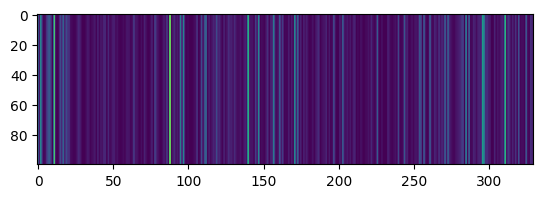

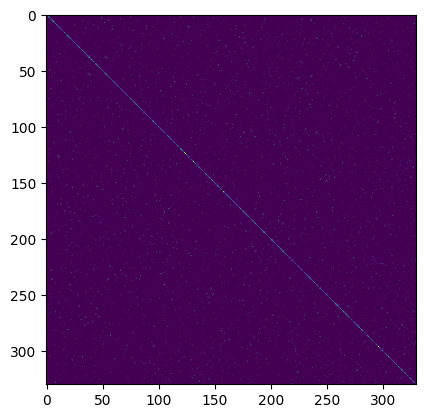

In [13]:
import matplotlib.pyplot as plt

plt.imshow(np.stack([pM]*100)); plt.show()
plt.imshow(pU_M); plt.show()

### Get IB model

In [15]:
model_fn = "./outputs/naming_model.pkl"
if os.path.exists(model_fn):
    model = modeling.IBNamingModel.from_pickle(model_fn)
else:
    # This takes days on a laptop, but will work
    model = modeling.get_ib_naming_model(
        pU_M,
        pM,
        # add custom beta values here
        betas=np.logspace(0, 5, 1600,)
    )

ModuleNotFoundError: No module named 'ultk.effcomm.ib'

## Load natural languages

In [ ]:
# Read the data
term_df = pd.read_csv(
    "data/term.txt", delimiter="\t", names=("lang", "spkr", "cnum", "term")
)

# Get the number of unique meanings and initialize variables
num_m = len(term_df.cnum.unique())

# Create a dictionary to store p(W|C) for each language
pW_C_dict = {}

# Process each language separately
for lang in tqdm(term_df.lang.unique()):
    # Subset the data for this language
    lang_df = term_df[term_df.lang == lang]
    
    # Map terms and categories to indices
    unique_terms = lang_df.term.unique()
    term_to_idx = {term: i for i, term in enumerate(unique_terms)}
    num_w = len(unique_terms)
    
    # Initialize p(W|C) matrix
    pW_C = np.zeros((num_m, num_w))
    
    # Populate the matrix
    for cnum, group in lang_df.groupby('cnum'):
        c_idx = cnum - 1  # Assuming cnum starts from 1
        term_counts = group['term'].value_counts()
        
        for term, count in term_counts.items():
            t_idx = term_to_idx[term]
            pW_C[c_idx, t_idx] = count
    
    # Normalize rows to get probabilities
    pW_C = pW_C / pW_C.sum(axis=1, keepdims=True)
    
    # Store the result for this language
    pW_C_dict[lang] = pW_C


In [ ]:
# langq = lambda lang: language_to_encoder(lang)
get_point = lambda q: (model.complexity(q), model.accuracy(q), model.d_IB(q))

df_langs = pd.DataFrame.from_records(
    [
        (key, )
        + get_point(q)
        for key, q in tqdm(pW_C_dict.items())
    ],
    columns=("language", "complexity", "accuracy", "distortion"),
)
df_langs

## Plot

In [ ]:
import plotnine as pn

In [ ]:
df_bound = pd.DataFrame(model.IB_curve.T, columns=["complexity", "accuracy"],)
df_bound

In [ ]:
(
    pn.ggplot(
        df_bound, 
        mapping=pn.aes(x="complexity", y="accuracy"),
    )  
    + pn.geom_line() # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    # natural langs
    + pn.geom_point( 
        data=df_langs,
        # alpha=0.3,
        size=3,
        fill="blue",
    )
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")
)